In [110]:
import sys
sys.path.append("../")
path = "../"

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfmm

%load_ext autoreload
%autoreload 2

from methods.implicit_perturb_2D import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
pip install tqdm

In [ ]:
pip install gstools

In [ ]:
pip install scikit-fmm

In [ ]:
pip install statsmodels

### Load initial + truth from image w/ thresholding

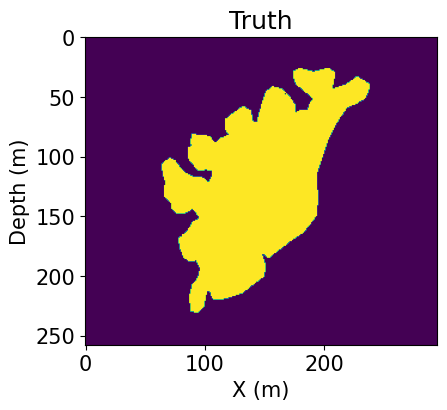

In [85]:
truth = cv2.imread('../data/data_gen_case/imgs/truth2.png', cv2.IMREAD_GRAYSCALE)
ret,thresh = cv2.threshold(truth, 20, 255, cv2.THRESH_BINARY)
thresh = (1 - ((thresh / 255) - 1) * -1)
truth = thresh

df = pd.DataFrame(truth)
df.to_csv('testing.csv')

plt.title('Truth')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.imshow(truth)
plt.show()

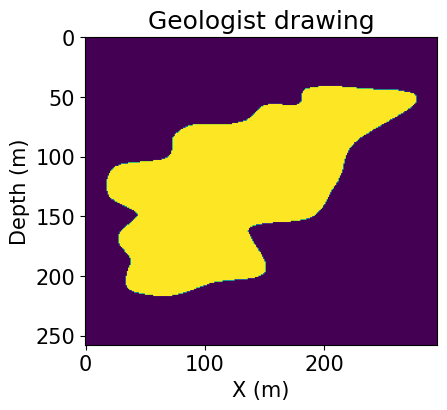

In [86]:
initial = cv2.imread('../data/data_gen_case/imgs/fake2.png', cv2.IMREAD_GRAYSCALE)

ret,thresh = cv2.threshold(initial, 20, 255, cv2.THRESH_BINARY)
thresh = (1 - ((thresh / 255) - 1) * -1)
initial = thresh

plt.title('Geologist drawing')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.imshow(initial)
plt.show()

### heatmap threshold testing

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import imageio

image_path = model
heatmap = image_path

if heatmap.shape[-1] == 4:
    heatmap = heatmap[..., :3]

if heatmap.ndim == 3:
    heatmap = np.mean(heatmap, axis=2)

plt.imshow(heatmap, cmap='viridis')
plt.colorbar()
plt.title('Geologist Drawing')
plt.xlabel('X (m)')
plt.ylabel('Depth (m)')
plt.show()

# Plot the histogram of the heatmap values
plt.hist(heatmap.ravel(), bins=256, fc='k', ec='k')
plt.title('Histogram of Heatmap Values')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()


In [ ]:
def binarize_heatmap(heatmap, threshold):
    binary_image = np.zeros_like(heatmap)
    binary_image[heatmap > threshold] = 1
    return binary_image

threshold = np.mean(heatmap) + 1.5 * np.std(heatmap)

binary_image = binarize_heatmap(heatmap, threshold)

plt.imshow(binary_image, cmap='gray')
plt.title('Binarized Heatmap')
plt.xlabel('X (m)')
plt.ylabel('Depth (m)')
plt.show()


## testing hand gen shape with a single point

In [ ]:
truth = pd.read_csv('../data/peanut_case/maybe_good_data.csv')
truth = np.array(truth)
DF = pd.DataFrame(truth)

plt.imshow(truth)
plt.title('Truth')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

In [ ]:
initial = pd.read_csv('../data/peanut_case/initial_data_maybe_good.csv')
initial = np.array(initial)
DF = pd.DataFrame(initial)

plt.imshow(initial)
plt.title('Initial')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

### Load new contact points

In [87]:
new_contacts = pd.read_csv("../data/data_gen_case/paths/img2_contacts.csv")

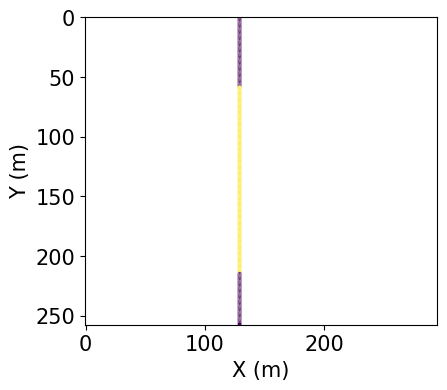

In [88]:
plt.imshow(truth, alpha = 0)
plt.scatter(new_contacts['x'], new_contacts['depth'],
            c=new_contacts['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.ylabel('Y (m)'), plt.xlabel('X (m)')
plt.show()


### Initial Model

In [89]:
x_dim, y_dim= truth.shape
print(truth.shape)
x0 = 50; a = 10
y0 = 50; b = 20

x = np.linspace(0, x_dim,x_dim)[:,None]  # x values of interest
y = np.linspace(0, y_dim,y_dim)[:]  # y values of interest, as a "column" array

initial = initial*1

(258, 295)


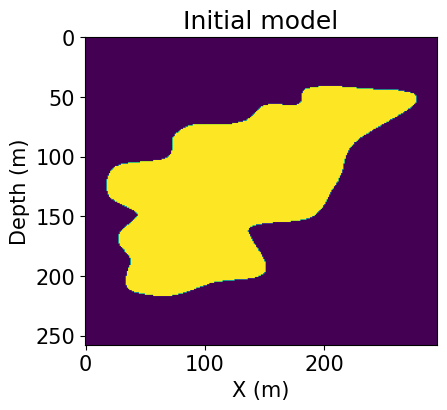

In [90]:
plt.imshow(initial)
plt.title('Initial model')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

### Trend estimation: MCMC on level sets M(x)

In [91]:
data = np.zeros(initial.shape)
data[:] = np.nan
data[np.array(new_contacts['depth'],dtype = 'int64'), np.array(new_contacts['x'], dtype = 'int64')] = truth[np.array(new_contacts['depth'], dtype = 'int64'), np.array(new_contacts['x'], dtype = 'int64')]
data[np.array(new_contacts[new_contacts['contacts']==1]['depth'],dtype = 'int64'),
     np.array(new_contacts[new_contacts['contacts']==1]['x'],dtype = 'int64')] = 0.5

In [92]:
initial = initial - 0.5
model = skfmm.distance(initial)

In [ ]:
# indicators_x_alpha = data[np.isfinite(data)]
# indicators_x_alpha[indicators_x_alpha==0.5]=1

# phi_x_alpha_ini = model[np.isfinite(data)]
# phi_x_beta_ini = model[data==0.5]

# loss_prev, o_ik_prev, o_bias_prev, o_var_prev =  loss_mean_function_v2(indicators_x_alpha,phi_x_alpha_ini,phi_x_beta_ini, model, data)
# print(loss_prev)
# sigma_coeff = 0.01
# print('sigma = ', loss_prev*sigma_coeff)
# print(o_ik_prev, o_bias_prev, o_var_prev)

In [93]:
#binarize img
threshold = np.mean(model) + np.std(model)
bin_img = bin_img_mask(model, threshold)
#plt.imshow(bin_img)
#plt.show()
model_curvature = curvature(bin_img)

reference_curvature = curvature(truth)

kl_div = curvatures_kl(model_curvature, reference_curvature, 10)

print(np.abs(kl_div))


0.1635617813074585


In [94]:
indicators_x_alpha = data[np.isfinite(data)]
indicators_x_alpha[indicators_x_alpha==0.5]=1

phi_x_alpha_ini = model[np.isfinite(data)]
phi_x_beta_ini = model[data==0.5]

reference_curvature = curvature(truth)

loss_prev, mean_loss, curvature_loss, o_ik_prev, o_bias_prev, o_var_prev = loss_function_mean_v2_curvature_kl(indicators_x_alpha, phi_x_alpha_ini, phi_x_beta_ini, model, data, reference_curvature, bins=10)
print("mean loss: " + str(mean_loss))
print("curvature loss: " + str(curvature_loss))
print("total loss: " + str(loss_prev))
sigma_coeff = 0.01
print('sigma = ', loss_prev*sigma_coeff)

TypeError: loss_function_mean_v2_curvature_kl() missing 2 required positional arguments: 'weight_mean_loss' and 'weight_curvature_loss'

#### run single chain

In [95]:
iter_num = 3000
[model_cache, loss_cache, para_cache] = McMC_levelsets_2Dv2_curvature(model, data, truth,
                                                loss_function=loss_function_mean_v2_curvature_kl,  
                                                hyper_sigma = 0.075, t_step = 1, iter_num = iter_num, 
                                                vel_range_x = [20, 40], vel_range_y = [20, 40],
                                                anisotropy_ang = [0, 180], num_mp = 0)
np.save('loss_cache.npy',loss_cache)
np.save('model_cache.npy',model_cache)
np.save('para_cache.npy',para_cache)

sigma: 0.15
mean loss: 396.57127194954444
curvature loss: 0.1635617813074585
total_loss:2.0


  1%|          | 21/3000 [00:21<48:13,  1.03it/s] 

Num_mp: 0Accept ratio: 0.3157894736842105, Loss function at iter 20: 1.011865119125658


  1%|▏         | 41/3000 [00:40<45:52,  1.08it/s]

Num_mp: 0Accept ratio: 0.15384615384615385, Loss function at iter 40: 1.011865119125658


  2%|▏         | 61/3000 [00:58<45:48,  1.07it/s]

Num_mp: 0Accept ratio: 0.13559322033898302, Loss function at iter 60: 0.9446972290679765


  3%|▎         | 81/3000 [01:17<45:25,  1.07it/s]

Num_mp: 0Accept ratio: 0.10126582278481011, Loss function at iter 80: 0.9446972290679765


  3%|▎         | 101/3000 [01:37<50:06,  1.04s/it] 

Num_mp: 0Accept ratio: 0.09090909090909094, Loss function at iter 100: 0.9476789947354742


  4%|▍         | 121/3000 [01:56<45:15,  1.06it/s]

Num_mp: 0Accept ratio: 0.07563025210084029, Loss function at iter 120: 0.9476789947354742


  5%|▍         | 141/3000 [02:16<45:27,  1.05it/s]

Num_mp: 0Accept ratio: 0.06474820143884896, Loss function at iter 140: 0.9476789947354742


  5%|▌         | 161/3000 [02:35<45:23,  1.04it/s]

Num_mp: 0Accept ratio: 0.05660377358490565, Loss function at iter 160: 0.9503646909076842


  6%|▌         | 181/3000 [02:54<44:14,  1.06it/s]

Num_mp: 0Accept ratio: 0.05586592178770955, Loss function at iter 180: 0.9503646909076842


  7%|▋         | 201/3000 [03:13<42:28,  1.10it/s]

Num_mp: 0Accept ratio: 0.06030150753768848, Loss function at iter 200: 0.9271403030606361


  7%|▋         | 221/3000 [03:32<43:22,  1.07it/s]

Num_mp: 0Accept ratio: 0.0547945205479452, Loss function at iter 220: 0.9271403030606361


  8%|▊         | 241/3000 [03:51<42:54,  1.07it/s]

Num_mp: 0Accept ratio: 0.05439330543933052, Loss function at iter 240: 0.9342070222784472


  9%|▊         | 261/3000 [04:10<41:38,  1.10it/s]

Num_mp: 0Accept ratio: 0.05405405405405406, Loss function at iter 260: 0.9580114784642364


  9%|▉         | 281/3000 [04:29<41:11,  1.10it/s]

Num_mp: 0Accept ratio: 0.05017921146953408, Loss function at iter 280: 0.9580114784642364


 10%|█         | 301/3000 [04:48<41:23,  1.09it/s]

Num_mp: 0Accept ratio: 0.04682274247491636, Loss function at iter 300: 0.9580114784642364


 11%|█         | 321/3000 [05:07<49:20,  1.11s/it]

Num_mp: 0Accept ratio: 0.050156739811912265, Loss function at iter 320: 0.946645895781144


 11%|█▏        | 341/3000 [05:26<41:31,  1.07it/s]

Num_mp: 0Accept ratio: 0.05014749262536877, Loss function at iter 340: 0.9464876805525797


 12%|█▏        | 361/3000 [05:45<41:43,  1.05it/s]

Num_mp: 0Accept ratio: 0.0473537604456824, Loss function at iter 360: 0.9464876805525797


 13%|█▎        | 381/3000 [06:04<41:30,  1.05it/s]

Num_mp: 0Accept ratio: 0.06068601583113453, Loss function at iter 380: 0.8836590959744846


 13%|█▎        | 401/3000 [06:24<51:34,  1.19s/it]

Num_mp: 0Accept ratio: 0.057644110275689275, Loss function at iter 400: 0.8836590959744846


 14%|█▍        | 421/3000 [06:43<39:50,  1.08it/s]

Num_mp: 0Accept ratio: 0.06205250596658707, Loss function at iter 420: 0.7813896444160862


 15%|█▍        | 441/3000 [07:01<39:41,  1.07it/s]

Num_mp: 0Accept ratio: 0.06833712984054674, Loss function at iter 440: 0.6731065831671942


 15%|█▌        | 461/3000 [07:20<40:03,  1.06it/s]

Num_mp: 0Accept ratio: 0.065359477124183, Loss function at iter 460: 0.6731065831671942


 16%|█▌        | 481/3000 [07:39<39:55,  1.05it/s]

Num_mp: 0Accept ratio: 0.06471816283924847, Loss function at iter 480: 0.6613268482789044


 17%|█▋        | 501/3000 [07:58<39:07,  1.06it/s]

Num_mp: 0Accept ratio: 0.06212424849699394, Loss function at iter 500: 0.6613268482789044


 17%|█▋        | 521/3000 [08:16<37:50,  1.09it/s]

Num_mp: 0Accept ratio: 0.05010020040080165, Loss function at iter 520: 0.6613268482789044


 18%|█▊        | 541/3000 [08:35<38:40,  1.06it/s]

Num_mp: 0Accept ratio: 0.05611222444889774, Loss function at iter 540: 0.5914162628239454


 19%|█▊        | 561/3000 [08:53<37:14,  1.09it/s]

Num_mp: 0Accept ratio: 0.05611222444889774, Loss function at iter 560: 0.6119363326019625


 19%|█▉        | 581/3000 [09:11<36:43,  1.10it/s]

Num_mp: 0Accept ratio: 0.05611222444889774, Loss function at iter 580: 0.6119363326019625


 20%|██        | 601/3000 [09:30<37:11,  1.08it/s]

Num_mp: 0Accept ratio: 0.05811623246492981, Loss function at iter 600: 0.5853201922555795


 21%|██        | 621/3000 [09:56<57:27,  1.45s/it]  

Num_mp: 0Accept ratio: 0.06212424849699394, Loss function at iter 620: 0.5059401969433275


 21%|██▏       | 641/3000 [10:15<37:09,  1.06it/s]

Num_mp: 0Accept ratio: 0.06613226452905807, Loss function at iter 640: 0.5063807300962837


 22%|██▏       | 661/3000 [10:33<36:30,  1.07it/s]

Num_mp: 0Accept ratio: 0.06813627254509014, Loss function at iter 660: 0.5052771895268094


 23%|██▎       | 681/3000 [10:52<35:28,  1.09it/s]

Num_mp: 0Accept ratio: 0.06813627254509014, Loss function at iter 680: 0.5052771895268094


 23%|██▎       | 701/3000 [11:10<34:50,  1.10it/s]

Num_mp: 0Accept ratio: 0.064128256513026, Loss function at iter 700: 0.4992374848943416


 24%|██▍       | 721/3000 [11:29<34:52,  1.09it/s]

Num_mp: 0Accept ratio: 0.0701402805611222, Loss function at iter 720: 0.4774315337057054


 25%|██▍       | 741/3000 [11:48<37:21,  1.01it/s]

Num_mp: 0Accept ratio: 0.07815631262525047, Loss function at iter 740: 0.4820242709524807


 25%|██▌       | 761/3000 [12:07<34:21,  1.09it/s]

Num_mp: 0Accept ratio: 0.08016032064128253, Loss function at iter 760: 0.4266725164986747


 26%|██▌       | 781/3000 [12:26<36:13,  1.02it/s]

Num_mp: 0Accept ratio: 0.08617234468937873, Loss function at iter 780: 0.29405825909076916


 27%|██▋       | 801/3000 [12:45<34:08,  1.07it/s]

Num_mp: 0Accept ratio: 0.09018036072144286, Loss function at iter 800: 0.278289156240768


 27%|██▋       | 821/3000 [13:05<38:56,  1.07s/it]

Num_mp: 0Accept ratio: 0.09018036072144286, Loss function at iter 820: 0.28347934898391125


 28%|██▊       | 841/3000 [13:26<34:53,  1.03it/s]

Num_mp: 0Accept ratio: 0.094188376753507, Loss function at iter 840: 0.250144752750485


 29%|██▊       | 861/3000 [13:45<33:51,  1.05it/s]

Num_mp: 0Accept ratio: 0.1002004008016032, Loss function at iter 860: 0.2726876988099117


 29%|██▉       | 881/3000 [14:04<32:56,  1.07it/s]

Num_mp: 0Accept ratio: 0.09018036072144286, Loss function at iter 880: 0.26343959834862474


 30%|███       | 901/3000 [14:23<32:44,  1.07it/s]

Num_mp: 0Accept ratio: 0.09619238476953906, Loss function at iter 900: 0.2517336818675403


 31%|███       | 921/3000 [14:42<33:48,  1.02it/s]

Num_mp: 0Accept ratio: 0.09819639278557113, Loss function at iter 920: 0.24903975909854245


 31%|███▏      | 941/3000 [15:01<33:51,  1.01it/s]

Num_mp: 0Accept ratio: 0.09619238476953906, Loss function at iter 940: 0.29528595321203466


 32%|███▏      | 961/3000 [15:20<32:15,  1.05it/s]

Num_mp: 0Accept ratio: 0.1002004008016032, Loss function at iter 960: 0.28915858523932786


 33%|███▎      | 981/3000 [15:39<31:32,  1.07it/s]

Num_mp: 0Accept ratio: 0.10420841683366733, Loss function at iter 980: 0.23513980947497712


 33%|███▎      | 1000/3000 [15:57<31:39,  1.05it/s]

Num_mp: 0Accept ratio: 0.11422845691382766, Loss function at iter 1000: 0.22054874136848995


 34%|███▍      | 1021/3000 [16:17<31:17,  1.05it/s]

Num_mp: 0Accept ratio: 0.11823647294589179, Loss function at iter 1020: 0.23146898511668235


 35%|███▍      | 1041/3000 [16:36<30:42,  1.06it/s]

Num_mp: 0Accept ratio: 0.11422845691382766, Loss function at iter 1040: 0.2303686006951404


 35%|███▌      | 1061/3000 [16:56<31:51,  1.01it/s]

Num_mp: 0Accept ratio: 0.11222444889779559, Loss function at iter 1060: 0.2761945343927429


 36%|███▌      | 1081/3000 [17:15<30:33,  1.05it/s]

Num_mp: 0Accept ratio: 0.12024048096192386, Loss function at iter 1080: 0.1867038029252564


 37%|███▋      | 1101/3000 [17:35<30:38,  1.03it/s]

Num_mp: 0Accept ratio: 0.12424849699398799, Loss function at iter 1100: 0.18430177943190532


 37%|███▋      | 1121/3000 [17:54<29:16,  1.07it/s]

Num_mp: 0Accept ratio: 0.13426853707414832, Loss function at iter 1120: 0.15194133432160303


 38%|███▊      | 1141/3000 [18:12<28:23,  1.09it/s]

Num_mp: 0Accept ratio: 0.13226452905811625, Loss function at iter 1140: 0.1549449488349361


 39%|███▊      | 1161/3000 [18:31<28:20,  1.08it/s]

Num_mp: 0Accept ratio: 0.14028056112224452, Loss function at iter 1160: 0.14182820678316957


 39%|███▉      | 1181/3000 [18:49<28:11,  1.08it/s]

Num_mp: 0Accept ratio: 0.14028056112224452, Loss function at iter 1180: 0.16154729511865681


 40%|████      | 1201/3000 [19:08<27:36,  1.09it/s]

Num_mp: 0Accept ratio: 0.14228456913827658, Loss function at iter 1200: 0.18919759803514824


 41%|████      | 1221/3000 [19:26<27:38,  1.07it/s]

Num_mp: 0Accept ratio: 0.14228456913827658, Loss function at iter 1220: 0.14113500296837014


 41%|████▏     | 1241/3000 [19:46<27:15,  1.08it/s]

Num_mp: 0Accept ratio: 0.14028056112224452, Loss function at iter 1240: 0.14231096702340434


 42%|████▏     | 1261/3000 [20:04<27:21,  1.06it/s]

Num_mp: 0Accept ratio: 0.13827655310621245, Loss function at iter 1260: 0.14592213232013257


 43%|████▎     | 1281/3000 [20:23<27:30,  1.04it/s]

Num_mp: 0Accept ratio: 0.13627254509018039, Loss function at iter 1280: 0.15273944584636132


 43%|████▎     | 1301/3000 [20:43<27:30,  1.03it/s]

Num_mp: 0Accept ratio: 0.14228456913827658, Loss function at iter 1300: 0.15560855655634906


 44%|████▍     | 1321/3000 [21:02<28:43,  1.03s/it]

Num_mp: 0Accept ratio: 0.14829659318637278, Loss function at iter 1320: 0.150116371318631


 45%|████▍     | 1341/3000 [21:22<26:37,  1.04it/s]

Num_mp: 0Accept ratio: 0.14428857715430865, Loss function at iter 1340: 0.1244781813664482


 45%|████▌     | 1361/3000 [21:41<25:53,  1.05it/s]

Num_mp: 0Accept ratio: 0.14428857715430865, Loss function at iter 1360: 0.11820599512586867


 46%|████▌     | 1381/3000 [22:01<26:07,  1.03it/s]

Num_mp: 0Accept ratio: 0.15430861723446898, Loss function at iter 1380: 0.1483740534685291


 47%|████▋     | 1401/3000 [22:20<25:44,  1.04it/s]

Num_mp: 0Accept ratio: 0.15430861723446898, Loss function at iter 1400: 0.08052014321753816


 47%|████▋     | 1421/3000 [22:40<25:33,  1.03it/s]

Num_mp: 0Accept ratio: 0.15030060120240485, Loss function at iter 1420: 0.24435346511152883


 48%|████▊     | 1441/3000 [22:59<25:14,  1.03it/s]

Num_mp: 0Accept ratio: 0.14629258517034072, Loss function at iter 1440: 0.08271120772786947


 49%|████▊     | 1461/3000 [23:19<24:42,  1.04it/s]

Num_mp: 0Accept ratio: 0.14428857715430865, Loss function at iter 1460: 0.16288586818025558


 49%|████▉     | 1481/3000 [23:38<24:00,  1.05it/s]

Num_mp: 0Accept ratio: 0.15631262525050105, Loss function at iter 1480: 0.11576897937212352


 50%|█████     | 1501/3000 [23:57<24:50,  1.01it/s]

Num_mp: 0Accept ratio: 0.15430861723446898, Loss function at iter 1500: 0.08103323429984269


 51%|█████     | 1521/3000 [24:16<23:24,  1.05it/s]

Num_mp: 0Accept ratio: 0.1643286573146293, Loss function at iter 1520: 0.1732204829605259


 51%|█████▏    | 1541/3000 [24:36<23:18,  1.04it/s]

Num_mp: 0Accept ratio: 0.1823647294589178, Loss function at iter 1540: 0.1275666620670995


 52%|█████▏    | 1561/3000 [24:54<22:21,  1.07it/s]

Num_mp: 0Accept ratio: 0.1943887775551102, Loss function at iter 1560: 0.11401277935249579


 53%|█████▎    | 1581/3000 [25:14<22:41,  1.04it/s]

Num_mp: 0Accept ratio: 0.20240480961923846, Loss function at iter 1580: 0.10288424352964379


 53%|█████▎    | 1601/3000 [25:33<22:14,  1.05it/s]

Num_mp: 0Accept ratio: 0.20440881763527052, Loss function at iter 1600: 0.07747737068576102


 54%|█████▍    | 1621/3000 [25:52<21:43,  1.06it/s]

Num_mp: 0Accept ratio: 0.2004008016032064, Loss function at iter 1620: 0.030596560845022394


 55%|█████▍    | 1641/3000 [26:11<21:19,  1.06it/s]

Num_mp: 0Accept ratio: 0.2004008016032064, Loss function at iter 1640: 0.02300523165244339


 55%|█████▌    | 1661/3000 [26:30<22:02,  1.01it/s]

Num_mp: 0Accept ratio: 0.19839679358717432, Loss function at iter 1660: 0.016605596896875484


 56%|█████▌    | 1681/3000 [26:49<21:02,  1.04it/s]

Num_mp: 0Accept ratio: 0.20440881763527052, Loss function at iter 1680: 0.14717333169821695


 57%|█████▋    | 1701/3000 [27:09<21:18,  1.02it/s]

Num_mp: 0Accept ratio: 0.2064128256513026, Loss function at iter 1700: 0.07276661009763176


 57%|█████▋    | 1721/3000 [27:28<20:47,  1.03it/s]

Num_mp: 0Accept ratio: 0.21643286573146292, Loss function at iter 1720: 0.18025521255303129


 58%|█████▊    | 1741/3000 [27:48<19:51,  1.06it/s]

Num_mp: 0Accept ratio: 0.2124248496993988, Loss function at iter 1740: 0.19311385087908237


 59%|█████▊    | 1761/3000 [28:07<19:37,  1.05it/s]

Num_mp: 0Accept ratio: 0.2124248496993988, Loss function at iter 1760: 0.18042711420377547


 59%|█████▉    | 1781/3000 [28:26<19:23,  1.05it/s]

Num_mp: 0Accept ratio: 0.22044088176352705, Loss function at iter 1780: 0.10973714993667665


 60%|██████    | 1801/3000 [28:45<19:26,  1.03it/s]

Num_mp: 0Accept ratio: 0.21643286573146292, Loss function at iter 1800: 0.041983561992827476


 61%|██████    | 1821/3000 [29:04<18:46,  1.05it/s]

Num_mp: 0Accept ratio: 0.21643286573146292, Loss function at iter 1820: 0.07269639344531253


 61%|██████▏   | 1841/3000 [29:23<18:07,  1.07it/s]

Num_mp: 0Accept ratio: 0.22244488977955912, Loss function at iter 1840: 0.1422428524286049


 62%|██████▏   | 1861/3000 [29:42<17:53,  1.06it/s]

Num_mp: 0Accept ratio: 0.22444889779559118, Loss function at iter 1860: 0.17410244070992667


 63%|██████▎   | 1881/3000 [30:01<17:53,  1.04it/s]

Num_mp: 0Accept ratio: 0.21643286573146292, Loss function at iter 1880: 0.22888007727567822


 63%|██████▎   | 1901/3000 [30:21<17:39,  1.04it/s]

Num_mp: 0Accept ratio: 0.22244488977955912, Loss function at iter 1900: 0.20203954973904997


 64%|██████▍   | 1921/3000 [30:40<17:06,  1.05it/s]

Num_mp: 0Accept ratio: 0.22244488977955912, Loss function at iter 1920: 0.19548190619923447


 65%|██████▍   | 1941/3000 [30:59<16:36,  1.06it/s]

Num_mp: 0Accept ratio: 0.22845691382765532, Loss function at iter 1940: 0.09112787816204487


 65%|██████▌   | 1961/3000 [31:18<16:36,  1.04it/s]

Num_mp: 0Accept ratio: 0.23046092184368738, Loss function at iter 1960: 0.0887125150180998


 66%|██████▌   | 1981/3000 [31:37<16:09,  1.05it/s]

Num_mp: 0Accept ratio: 0.218436873747495, Loss function at iter 1980: 0.17664376482449384


 67%|██████▋   | 2000/3000 [31:55<15:57,  1.04it/s]

Num_mp: 0Accept ratio: 0.22044088176352705, Loss function at iter 2000: 0.15877391656577117


 67%|██████▋   | 2021/3000 [32:17<15:34,  1.05it/s]

Num_mp: 0Accept ratio: 0.22044088176352705, Loss function at iter 2020: 0.0907198374317972


 68%|██████▊   | 2041/3000 [32:36<14:59,  1.07it/s]

Num_mp: 0Accept ratio: 0.20240480961923846, Loss function at iter 2040: 0.09370460135858721


 69%|██████▊   | 2061/3000 [32:55<14:43,  1.06it/s]

Num_mp: 0Accept ratio: 0.19839679358717432, Loss function at iter 2060: 0.12174464142332876


 69%|██████▉   | 2081/3000 [33:14<14:41,  1.04it/s]

Num_mp: 0Accept ratio: 0.19238476953907813, Loss function at iter 2080: 0.06856312241405255


 70%|███████   | 2101/3000 [33:34<14:19,  1.05it/s]

Num_mp: 0Accept ratio: 0.18637274549098193, Loss function at iter 2100: 0.05956789309146904


 71%|███████   | 2121/3000 [33:53<13:59,  1.05it/s]

Num_mp: 0Accept ratio: 0.1763527054108216, Loss function at iter 2120: 0.05956789309146904


 71%|███████▏  | 2141/3000 [34:12<13:43,  1.04it/s]

Num_mp: 0Accept ratio: 0.1823647294589178, Loss function at iter 2140: 0.12191060525089822


 72%|███████▏  | 2161/3000 [34:33<15:07,  1.08s/it]

Num_mp: 0Accept ratio: 0.18436873747494986, Loss function at iter 2160: 0.07693410141758622


 73%|███████▎  | 2181/3000 [34:52<12:48,  1.07it/s]

Num_mp: 0Accept ratio: 0.18436873747494986, Loss function at iter 2180: 0.08053640804603883


 73%|███████▎  | 2201/3000 [35:12<12:41,  1.05it/s]

Num_mp: 0Accept ratio: 0.1823647294589178, Loss function at iter 2200: 0.07111992627830929


 74%|███████▍  | 2221/3000 [35:30<12:28,  1.04it/s]

Num_mp: 0Accept ratio: 0.17434869739478953, Loss function at iter 2220: 0.07493578043194382


 75%|███████▍  | 2241/3000 [35:49<11:45,  1.08it/s]

Num_mp: 0Accept ratio: 0.17835671342685366, Loss function at iter 2240: 0.12870852752821488


 75%|███████▌  | 2261/3000 [36:08<11:33,  1.07it/s]

Num_mp: 0Accept ratio: 0.1763527054108216, Loss function at iter 2260: 0.12069780901508342


 76%|███████▌  | 2281/3000 [36:27<11:11,  1.07it/s]

Num_mp: 0Accept ratio: 0.16833667334669333, Loss function at iter 2280: 0.19874247540783077


 77%|███████▋  | 2301/3000 [36:47<11:03,  1.05it/s]

Num_mp: 0Accept ratio: 0.1703406813627254, Loss function at iter 2300: 0.08230848417337379


 77%|███████▋  | 2321/3000 [37:06<10:26,  1.08it/s]

Num_mp: 0Accept ratio: 0.17234468937875747, Loss function at iter 2320: 0.14954396417397614


 78%|███████▊  | 2341/3000 [37:25<10:18,  1.06it/s]

Num_mp: 0Accept ratio: 0.16633266533066138, Loss function at iter 2340: 0.13775301974824816


 79%|███████▊  | 2361/3000 [37:44<10:02,  1.06it/s]

Num_mp: 0Accept ratio: 0.16232464929859725, Loss function at iter 2360: 0.18211991196416655


 79%|███████▉  | 2381/3000 [38:05<10:02,  1.03it/s]

Num_mp: 0Accept ratio: 0.1643286573146293, Loss function at iter 2380: 0.12394739513403169


 80%|████████  | 2401/3000 [38:24<09:22,  1.07it/s]

Num_mp: 0Accept ratio: 0.15230460921843691, Loss function at iter 2400: 0.12394739513403169


 81%|████████  | 2421/3000 [38:44<09:08,  1.06it/s]

Num_mp: 0Accept ratio: 0.15230460921843691, Loss function at iter 2420: 0.10112370706055746


 81%|████████▏ | 2441/3000 [39:03<08:57,  1.04it/s]

Num_mp: 0Accept ratio: 0.14829659318637278, Loss function at iter 2440: 0.14809343062457314


 82%|████████▏ | 2461/3000 [39:23<08:42,  1.03it/s]

Num_mp: 0Accept ratio: 0.14629258517034072, Loss function at iter 2460: 0.173463466720527


 83%|████████▎ | 2481/3000 [39:42<08:08,  1.06it/s]

Num_mp: 0Accept ratio: 0.14629258517034072, Loss function at iter 2480: 0.1302213318227331


 83%|████████▎ | 2501/3000 [40:01<07:41,  1.08it/s]

Num_mp: 0Accept ratio: 0.14428857715430865, Loss function at iter 2500: 0.19891558729800568


 84%|████████▍ | 2521/3000 [40:20<07:35,  1.05it/s]

Num_mp: 0Accept ratio: 0.13426853707414832, Loss function at iter 2520: 0.2317542593204861


 85%|████████▍ | 2541/3000 [40:39<07:09,  1.07it/s]

Num_mp: 0Accept ratio: 0.13627254509018039, Loss function at iter 2540: 0.09553468375834905


 85%|████████▌ | 2561/3000 [40:58<06:43,  1.09it/s]

Num_mp: 0Accept ratio: 0.1302605210420842, Loss function at iter 2560: 0.07781133716654634


 86%|████████▌ | 2581/3000 [41:17<06:28,  1.08it/s]

Num_mp: 0Accept ratio: 0.12224448897795592, Loss function at iter 2580: 0.08849916194659821


 87%|████████▋ | 2601/3000 [41:36<06:12,  1.07it/s]

Num_mp: 0Accept ratio: 0.12424849699398799, Loss function at iter 2600: 0.10490701680791954


 87%|████████▋ | 2621/3000 [41:55<05:52,  1.07it/s]

Num_mp: 0Accept ratio: 0.12825651302605212, Loss function at iter 2620: 0.07930772974083332


 88%|████████▊ | 2641/3000 [42:14<05:39,  1.06it/s]

Num_mp: 0Accept ratio: 0.12024048096192386, Loss function at iter 2640: 0.09335324930297739


 89%|████████▊ | 2661/3000 [42:33<05:15,  1.07it/s]

Num_mp: 0Accept ratio: 0.11422845691382766, Loss function at iter 2660: 0.103464249419343


 89%|████████▉ | 2681/3000 [42:52<04:58,  1.07it/s]

Num_mp: 0Accept ratio: 0.11022044088176353, Loss function at iter 2680: 0.06261126531348508


 90%|█████████ | 2701/3000 [43:12<04:42,  1.06it/s]

Num_mp: 0Accept ratio: 0.11422845691382766, Loss function at iter 2700: 0.07680707485816016


 91%|█████████ | 2721/3000 [43:33<04:59,  1.07s/it]

Num_mp: 0Accept ratio: 0.10821643286573146, Loss function at iter 2720: 0.06869619237388483


 91%|█████████▏| 2741/3000 [43:53<04:10,  1.03it/s]

Num_mp: 0Accept ratio: 0.11422845691382766, Loss function at iter 2740: 0.07612617888799755


 92%|█████████▏| 2761/3000 [44:12<03:48,  1.05it/s]

Num_mp: 0Accept ratio: 0.11422845691382766, Loss function at iter 2760: 0.11247898365921344


 93%|█████████▎| 2781/3000 [44:31<03:33,  1.02it/s]

Num_mp: 0Accept ratio: 0.11823647294589179, Loss function at iter 2780: 0.11270338366568713


 93%|█████████▎| 2801/3000 [44:50<03:20,  1.01s/it]

Num_mp: 0Accept ratio: 0.11623246492985972, Loss function at iter 2800: 0.08069644720712556


 94%|█████████▍| 2821/3000 [45:09<02:51,  1.05it/s]

Num_mp: 0Accept ratio: 0.11022044088176353, Loss function at iter 2820: 0.16352961085722956


 95%|█████████▍| 2841/3000 [45:28<02:28,  1.07it/s]

Num_mp: 0Accept ratio: 0.10821643286573146, Loss function at iter 2840: 0.06494030648775202


 95%|█████████▌| 2861/3000 [45:47<02:11,  1.06it/s]

Num_mp: 0Accept ratio: 0.11222444889779559, Loss function at iter 2860: 0.08550751232056389


 96%|█████████▌| 2881/3000 [46:07<01:58,  1.00it/s]

Num_mp: 0Accept ratio: 0.11422845691382766, Loss function at iter 2880: 0.050256368226070255


 97%|█████████▋| 2901/3000 [46:27<01:38,  1.01it/s]

Num_mp: 0Accept ratio: 0.12024048096192386, Loss function at iter 2900: 0.08384470356222104


 97%|█████████▋| 2921/3000 [46:47<01:15,  1.05it/s]

Num_mp: 0Accept ratio: 0.12024048096192386, Loss function at iter 2920: 0.11398174180785689


 98%|█████████▊| 2941/3000 [47:06<00:54,  1.08it/s]

Num_mp: 0Accept ratio: 0.12224448897795592, Loss function at iter 2940: 0.3267473596573399


 99%|█████████▊| 2961/3000 [47:26<00:40,  1.04s/it]

Num_mp: 0Accept ratio: 0.12024048096192386, Loss function at iter 2960: 0.09358195799472112


 99%|█████████▉| 2981/3000 [47:47<00:18,  1.05it/s]

Num_mp: 0Accept ratio: 0.12024048096192386, Loss function at iter 2980: 0.06553696493808286


100%|██████████| 3000/3000 [48:06<00:00,  1.04it/s]


In [96]:
loss_cache = np.load(path+'notebook/loss_cache.npy')
model_cache = np.load(path+'notebook/model_cache.npy')
para_cache = np.load(path+'notebook/para_cache.npy')

#### run multichain

In [111]:
import multiprocessing
iter_num = 3000

sigma = 0.1

input_list = [[model, data, truth, loss_function_mean_v2_curvature_kl, sigma,  1, iter_num, [50,100], [30,60],  [0,180], 13],
              [model, data, truth, loss_function_mean_v2_curvature_kl, sigma, 1, iter_num, [70,140], [30,60], [0,180], 14],
              [model, data, truth, loss_function_mean_v2_curvature_kl, sigma,  1, iter_num, [90,180], [30,60], [0,180], 15]]

# Trend estimation, McMC
# 6 runs
# the start indicate where we retrieve our velocity
if __name__ == '__main__':
    pool = multiprocessing.Pool(processes = 3)
    result = pool.map(mp_non_stationary_implicit_2D_w_curvature,input_list)
    pool.close()

Num_mp: 14Accept ratio: 0.2545090180360722, Loss function at iter 2740: 0.31402542231020003


 92%|█████████▏| 2766/3000 [1:06:08<05:26,  1.40s/it]

Num_mp: 13Accept ratio: 0.2585170340681363, Loss function at iter 2720: 0.10635581470962292


 92%|█████████▏| 2756/3000 [1:06:30<06:17,  1.55s/it]

Num_mp: 15Accept ratio: 0.12825651302605212, Loss function at iter 2780: 0.15806209970487542


 91%|█████████▏| 2740/3000 [1:06:37<06:54,  1.59s/it]

Num_mp: 14Accept ratio: 0.2464929859719439, Loss function at iter 2760: 0.2661244434199679


 93%|█████████▎| 2786/3000 [1:06:38<05:46,  1.62s/it]

Num_mp: 13Accept ratio: 0.27254509018036077, Loss function at iter 2740: 0.2610684092348403


 93%|█████████▎| 2801/3000 [1:07:02<05:00,  1.51s/it]

Num_mp: 15Accept ratio: 0.13226452905811625, Loss function at iter 2800: 0.15024095142537736


 92%|█████████▏| 2760/3000 [1:07:07<05:51,  1.47s/it]

Num_mp: 14Accept ratio: 0.2525050100200401, Loss function at iter 2780: 0.23804220354549446


 92%|█████████▏| 2761/3000 [1:07:08<05:48,  1.46s/it]

Num_mp: 13Accept ratio: 0.2665330661322646, Loss function at iter 2760: 0.1728619413568018


 94%|█████████▍| 2821/3000 [1:07:32<04:12,  1.41s/it]

Num_mp: 15Accept ratio: 0.13426853707414832, Loss function at iter 2820: 0.4521038550942616


 93%|█████████▎| 2781/3000 [1:07:37<04:59,  1.37s/it]

Num_mp: 13Accept ratio: 0.26252505010020044, Loss function at iter 2780: 0.148713792552553


 93%|█████████▎| 2782/3000 [1:07:39<04:57,  1.36s/it]

Num_mp: 14Accept ratio: 0.2404809619238477, Loss function at iter 2800: 0.2847598152794249


 93%|█████████▎| 2796/3000 [1:07:59<04:56,  1.45s/it]

Num_mp: 15Accept ratio: 0.13827655310621245, Loss function at iter 2840: 0.11882561614784452


 94%|█████████▍| 2820/3000 [1:08:06<04:17,  1.43s/it]

Num_mp: 13Accept ratio: 0.2645290581162325, Loss function at iter 2800: 0.1436890522257767


 95%|█████████▍| 2846/3000 [1:08:06<03:29,  1.36s/it]

Num_mp: 14Accept ratio: 0.23847695390781565, Loss function at iter 2820: 0.17531512451500073


 94%|█████████▍| 2835/3000 [1:08:27<03:46,  1.37s/it]

Num_mp: 15Accept ratio: 0.14028056112224452, Loss function at iter 2860: 0.17951695382915467


 96%|█████████▌| 2866/3000 [1:08:35<03:05,  1.38s/it]

Num_mp: 13Accept ratio: 0.26252505010020044, Loss function at iter 2820: 0.2594659310468902


 94%|█████████▍| 2821/3000 [1:08:35<04:10,  1.40s/it]

Num_mp: 14Accept ratio: 0.22244488977955912, Loss function at iter 2840: 0.1839899201134577


 94%|█████████▍| 2835/3000 [1:08:54<03:46,  1.37s/it]

Num_mp: 15Accept ratio: 0.14428857715430865, Loss function at iter 2880: 0.2343332312507122


 95%|█████████▌| 2861/3000 [1:09:03<03:13,  1.39s/it]

Num_mp: 14Accept ratio: 0.2124248496993988, Loss function at iter 2860: 0.3502665523766415
Num_mp: 13Accept ratio: 0.2705410821643287, Loss function at iter 2840: 0.12905070411839434


 95%|█████████▌| 2855/3000 [1:09:23<03:21,  1.39s/it]

Num_mp: 15Accept ratio: 0.14228456913827658, Loss function at iter 2900: 0.14841909134058343


 95%|█████████▌| 2861/3000 [1:09:31<03:19,  1.43s/it]

Num_mp: 13Accept ratio: 0.27254509018036077, Loss function at iter 2860: 0.19185142975810937
Num_mp: 14Accept ratio: 0.2124248496993988, Loss function at iter 2880: 0.32452159321491064


 97%|█████████▋| 2921/3000 [1:09:55<01:57,  1.49s/it]

Num_mp: 15Accept ratio: 0.13226452905811625, Loss function at iter 2920: 0.1508045713623788


 97%|█████████▋| 2900/3000 [1:10:02<02:35,  1.55s/it]

Num_mp: 13Accept ratio: 0.27855711422845686, Loss function at iter 2880: 0.21079005804245737


 97%|█████████▋| 2901/3000 [1:10:04<02:31,  1.53s/it]

Num_mp: 14Accept ratio: 0.21442885771543085, Loss function at iter 2900: 0.2620157791629809


 98%|█████████▊| 2941/3000 [1:10:24<01:22,  1.40s/it]

Num_mp: 15Accept ratio: 0.12825651302605212, Loss function at iter 2940: 0.1508045713623788


 97%|█████████▋| 2921/3000 [1:10:32<01:42,  1.29s/it]

Num_mp: 14Accept ratio: 0.2124248496993988, Loss function at iter 2920: 0.14556364282873094
Num_mp: 13Accept ratio: 0.27855711422845686, Loss function at iter 2900: 0.2370216834140691


 97%|█████████▋| 2914/3000 [1:10:51<02:21,  1.65s/it]

Num_mp: 15Accept ratio: 0.13627254509018039, Loss function at iter 2960: 0.271854616825386


 99%|█████████▉| 2967/3000 [1:11:00<00:45,  1.38s/it]

Num_mp: 14Accept ratio: 0.20440881763527052, Loss function at iter 2940: 0.1364593624189657
Num_mp: 13Accept ratio: 0.2925851703406813, Loss function at iter 2920: 0.07049191506302953


 98%|█████████▊| 2935/3000 [1:11:21<01:35,  1.46s/it]

Num_mp: 15Accept ratio: 0.14028056112224452, Loss function at iter 2980: 0.16948986595758161


 99%|█████████▊| 2961/3000 [1:11:29<00:55,  1.42s/it]

Num_mp: 14Accept ratio: 0.19639278557114226, Loss function at iter 2960: 0.2564647422286529
Num_mp: 13Accept ratio: 0.29659318637274545, Loss function at iter 2940: 0.2288625120230187


 99%|█████████▊| 2960/3000 [1:11:56<00:47,  1.19s/it]

Num_mp: 14Accept ratio: 0.19238476953907813, Loss function at iter 2980: 0.18788652543618495


 99%|█████████▉| 2981/3000 [1:11:57<00:22,  1.18s/it]

Num_mp: 13Accept ratio: 0.3006012024048096, Loss function at iter 2960: 0.2553131197671077


 99%|█████████▉| 2980/3000 [1:12:24<00:24,  1.22s/it]

Num_mp: 13Accept ratio: 0.30260521042084165, Loss function at iter 2980: 0.0668431175828706


100%|██████████| 3000/3000 [1:12:45<00:00,  1.46s/it]


## Combining chains

#### If Gelmen_Rubin_Diagnostic < 1.1, then the chains have converged

#### single chain

In [14]:
def Gelmen_Rubin_Diagnostic(chain1, chain2, burn_in = 10000,length = 20000):
    
    n = chain1[burn_in:burn_in+length].shape[0]
    print(n)
    W = (chain1[burn_in:burn_in+length].std()**2 + chain2[burn_in:burn_in+length].std()**2)/2
    mean1 = chain1[burn_in:burn_in+length].mean()
    mean2 = chain2[burn_in:burn_in+length].mean()
    mean = (mean1 + mean2)/2
    B = n * ((mean1 - mean)**2 + (mean2 - mean)**2)
    var_theta = (1 - 1/n) * W + 1/n*B
    
    return np.sqrt(var_theta/W)

#### check multiple chains and search for deviations (> 1.1)

In [112]:
def multi_chain_gelman_rubin_diagnostic(chains, burn_in, length):
    segments = [chain[burn_in:burn_in+length] for chain in chains]
    n = segments[0].shape[0]
    W = np.mean([np.var(seg, ddof=1) for seg in segments])
    means = np.array([np.mean(seg) for seg in segments])
    overall_mean = np.mean(means)
    B = segments[0].shape[0] * np.var(means, ddof=1)
    var_theta  = (1 - 1/n) * W + 1/n*B
    R_hat = np.sqrt(var_theta / W)

    deviations = np.abs(means - overall_mean) > 2 * np.sqrt(W)
    if np.any(deviations):
        print("deviations: ", np.where(deviations)[0])

    return R_hat

In [113]:
# range of model numbers to display
num = 13
num_models = 3

In [114]:
model_cache_13 = np.load(path + 'results/Case2_intrusion/13_trend_cache.npy')
model_cache_14 = np.load(path + 'results/Case2_intrusion/14_trend_cache.npy')
model_cache_15 = np.load(path + 'results/Case2_intrusion/15_trend_cache.npy')

loss_cache_13 = np.load(path + 'results/Case2_intrusion/13_loss_cache.npy')
loss_cache_14 = np.load(path + 'results/Case2_intrusion/14_loss_cache.npy')
loss_cache_15 = np.load(path + 'results/Case2_intrusion/15_loss_cache.npy')

para_cache_13 = np.load(path + 'results/Case2_intrusion/13_para_cache.npy')
para_cache_14 = np.load(path + 'results/Case2_intrusion/14_para_cache.npy')
para_cache_15 = np.load(path + 'results/Case2_intrusion/15_para_cache.npy')


In [115]:
chains = [model_cache_13, model_cache_14, model_cache_15]
loss_caches = [loss_cache_13, loss_cache_14, loss_cache_15]
para_caches = [para_cache_13, para_cache_14, para_cache_15]

R_hat = multi_chain_gelman_rubin_diagnostic(chains, burn_in = 300,length = 3000)
print("Gelman-Rubin Diagnostic (R-hat):", R_hat)

Gelman-Rubin Diagnostic (R-hat): 1.000260286924473


#### combine chains and calculate summary

In [116]:
def combine_chains(chains, burn_in, length):
    # discard burn-in and combine
    segments = [chain[burn_in:burn_in+length] for chain in chains]
    combined_chains = np.concatenate([seg for seg in segments])
    return combined_chains

take last 2000 -> plot one chain then another
plot only for 0-2000 and then 4 times

In [117]:
for i in range(num_models):
    print(chains[i].shape)

(3000, 258, 295)
(3000, 258, 295)
(3000, 258, 295)


In [118]:
combined_model = combine_chains(chains, burn_in = 300,length = 3000)
model_cache = combined_model

print(model_cache.shape)

(8100, 258, 295)


Text(0, 0.5, 'Loss')

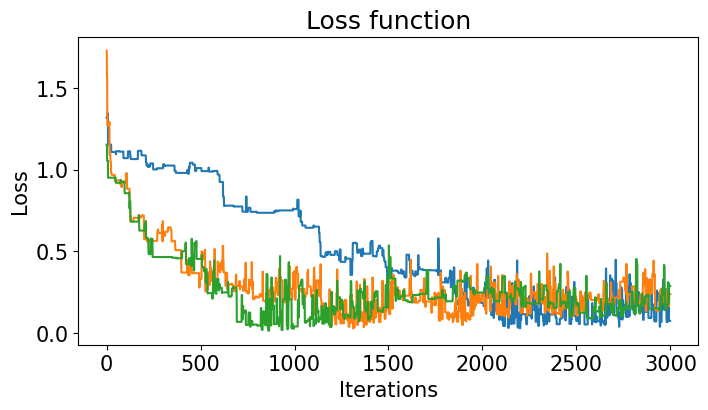

In [119]:
plt.rcParams["figure.figsize"] = (8, 4) 
for loss_cache in loss_caches:
    plt.plot(loss_cache[:], label='')
# plt.plot(loss_cache[:], label='')
plt.title('Loss function')
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [120]:
for para_cache in para_caches:
    para_cache[para_cache==-1] = np.nan
# para_cache[para_cache==-1] = np.nan

Text(0, 0.5, 'Loss')

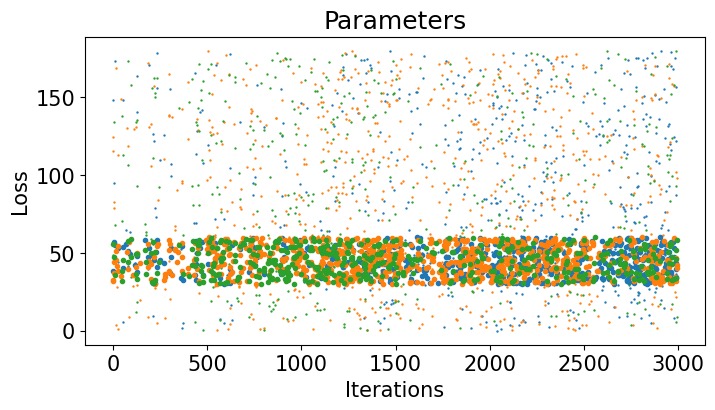

In [121]:
plt.rcParams["figure.figsize"] = (8, 4) 
iter_num = 3000
for para_cache in para_caches:
    plt.scatter(np.arange(iter_num),para_cache[:,2],s = 0.5)
    plt.plot(para_cache[:,1],'.')

# plt.scatter(np.arange(iter_num),para_cache[:,2],s = 0.5)
# plt.plot(para_cache[:,1],'.')

#plt.hist(para_cache[:,2])
#plt.hist(para_cache[:,3])
#plt.title('Loss function')
plt.title('Parameters')
plt.xlabel('Iterations')
plt.ylabel('Loss')

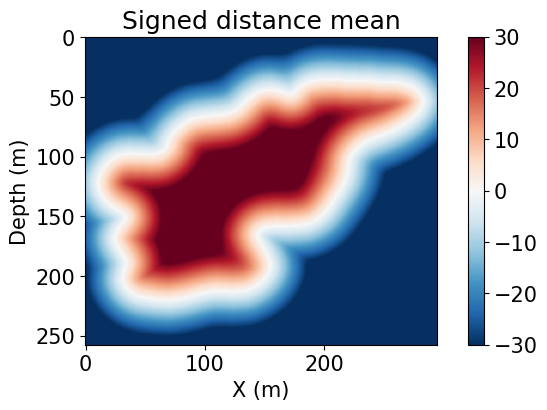

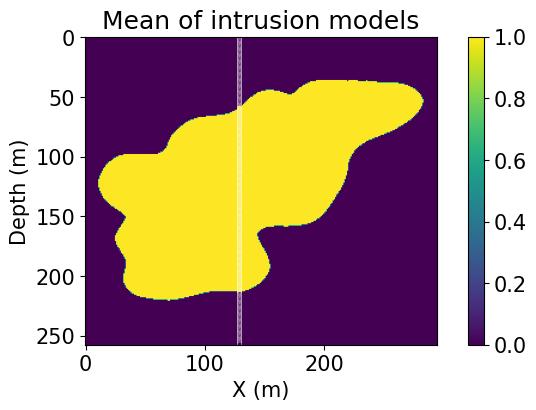

In [122]:
plt.imshow(np.mean(model_cache[1000:,:,:],axis = 0),vmin = -30,vmax =30,cmap = 'RdBu_r')
plt.colorbar()
plt.title('Signed distance mean')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

plt.imshow(np.mean(model_cache[1000:,:,:],axis = 0)>0)
plt.colorbar()
plt.scatter(new_contacts['x'], new_contacts['depth'],
            c=new_contacts['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.title('Mean of intrusion models')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

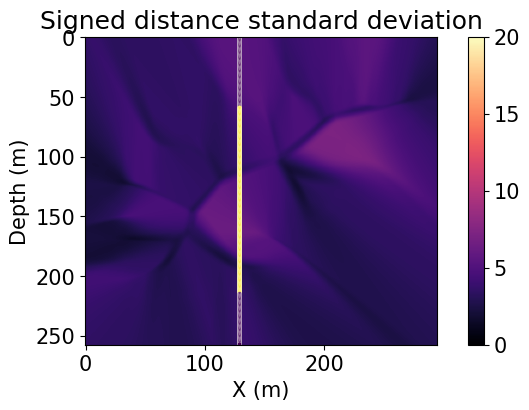

In [123]:
plt.imshow(np.std(model_cache[1000:,:,:],axis = 0),vmin = 0,vmax = 20, cmap = 'magma')
plt.colorbar()
plt.title('Signed distance standard deviation')
plt.scatter(new_contacts['x'], new_contacts['depth'],
            c=new_contacts['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

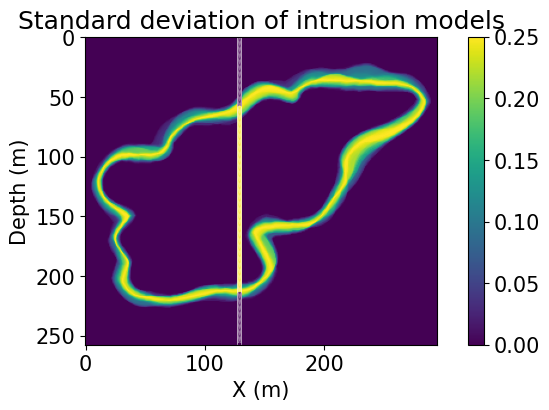

In [124]:
plt.imshow((np.var(model_cache[1000:,:,:]>0,axis = 0)))
plt.colorbar()
plt.title('Standard deviation of intrusion models')
plt.scatter(new_contacts['x'], new_contacts['depth'],
            c=new_contacts['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

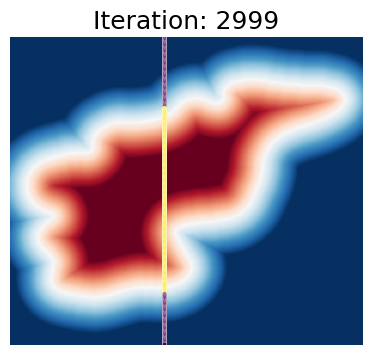

In [125]:
idx = 3000 - 1

plt.imshow(model_cache[idx,:,:],vmin = -30,vmax =30,cmap = 'RdBu_r')
#plt.colorbar()
plt.scatter(new_contacts['x'], new_contacts['depth'],
            c=new_contacts['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.title('Iteration: '+str(idx))
#plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'Trace plot')

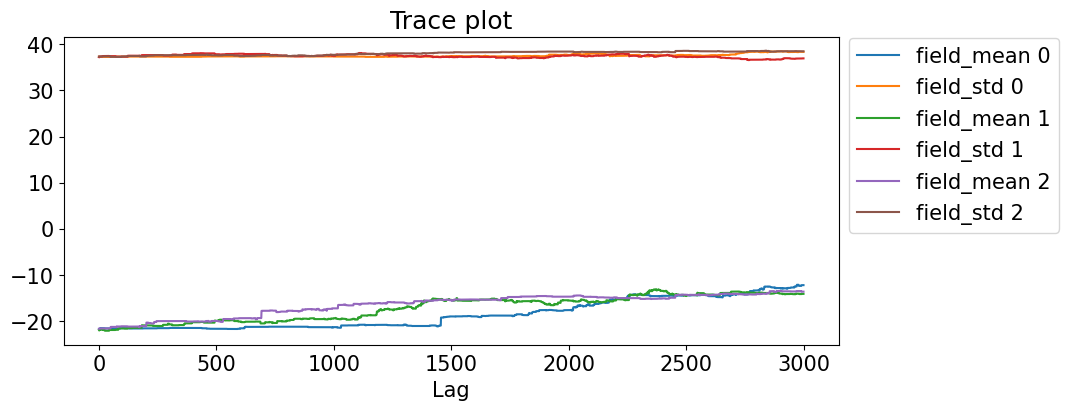

In [126]:
iter_num = 3000

count = 0
for nchain in chains:
    model_cache_mean = np.mean(nchain.reshape(iter_num,-1),axis = 1)
    model_cache_std = np.std(nchain.reshape(iter_num,-1),axis = 1)
    plt.rcParams.update({'font.size': 15})
    plt.rcParams["figure.figsize"] = (10, 4) 
    plt.plot(model_cache_mean,label = ('field_mean '  + str(count)))
    plt.plot(model_cache_std,label = ('field_std '  + str(count)))
    count += 1

# model_cache_mean = np.mean(model_cache.reshape(iter_num,-1),axis = 1)
# model_cache_std = np.std(model_cache.reshape(iter_num,-1),axis = 1)
# plt.rcParams.update({'font.size': 15})
# plt.rcParams["figure.figsize"] = (10, 4) 
# plt.plot(model_cache_mean,label = ('field_mean '))
# plt.plot(model_cache_std,label = ('field_std'))


# plt.plot(model_cache[:,50,50],label = 'loc1')
# plt.plot(model_cache[:,99,99],label = 'loc2')

plt.legend(bbox_to_anchor=(1., 1.03))
plt.xlabel('Lag')
plt.title('Trace plot')

In [127]:
cut_off = 300
from statsmodels.tsa.stattools import acf

acf_values_nchains = []
for nchain in chains:
    acf_values = np.zeros((2700,nchain.shape[1],nchain.shape[2]))
    for i in tqdm(range(nchain.shape[1])):
        for j in range(nchain.shape[2]):
            acf_values[:,i,j] = acf(nchain[cut_off:,i,j],nlags = 10000)
    acf_values_nchains.append(acf_values)

100%|██████████| 258/258 [00:13<00:00, 19.73it/s]


Text(0.5, 1.0, 'Mean autocorrelation of all grids')

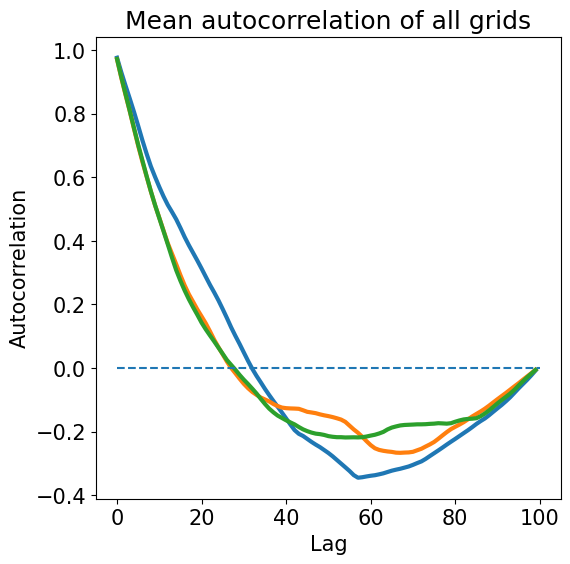

In [128]:
plt.rcParams["figure.figsize"] = (6, 6) 
for acf_values in acf_values_nchains:
    plt.plot(np.mean(acf_values.reshape(100,-1),axis =1),linewidth = 3)
plt.hlines(xmin = 0, xmax = 100,y = 0,linestyle = '--')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Mean autocorrelation of all grids')

In [129]:
### acceptance rate curve
acc_rate_nchains = []

for loss_cache in loss_caches:
    acc_rate = np.zeros(iter_num)
    acc_rate[:] = np.nan

    for iteration in np.arange(1,iter_num):
        acc_rate[iteration] = 1-np.sum((loss_cache[1:(iteration+1)]-loss_cache[0:iteration])==0)/iteration
    acc_rate_nchains.append(acc_rate)

Text(0.5, 1.0, 'Acceptance rate')

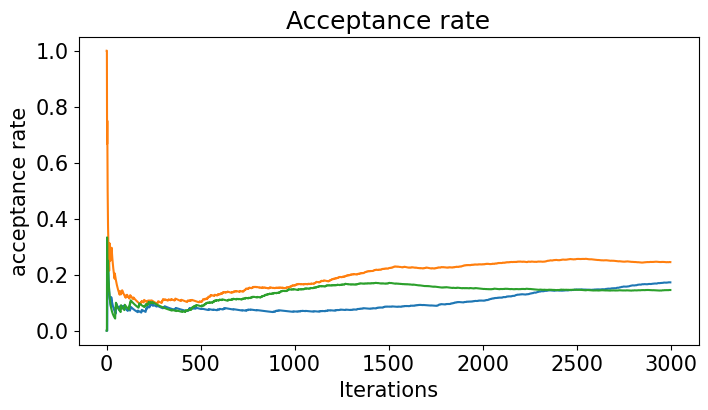

In [130]:
plt.rcParams["figure.figsize"] = (8, 4) 
for acc_rate in acc_rate_nchains:
    plt.plot(np.arange(1,iter_num),acc_rate[1:])
    # plt.text(iter_num-2000, 0.5+0.1, np.round(acc_rate[-1],2))
plt.ylabel('acceptance rate')
plt.xlabel('Iterations')
plt.title('Acceptance rate')

## residual simulation, velocity extension on each trend

### signed distance for each contact point

In [131]:
idx_at_contact = np.abs(np.gradient(data,axis = 0))>0

In [132]:
mc_pos_sdf = np.copy(model_cache[cut_off:,:,:])
sdf_at_contact = np.zeros((mc_pos_sdf.shape[0],np.sum(idx_at_contact)))
for i in tqdm(range(mc_pos_sdf.shape[0])):
    #mc_pos_sdf[i,:,:] = skfmm.distance(mc_pos[i,:,:]-0.5)
    sdf_at_contact[i,:] = mc_pos_sdf[i,:,:][idx_at_contact]

100%|██████████| 7800/7800 [00:00<00:00, 9994.91it/s] 


Text(0.5, 1.0, 'Histogram of signed distance at the contact points')

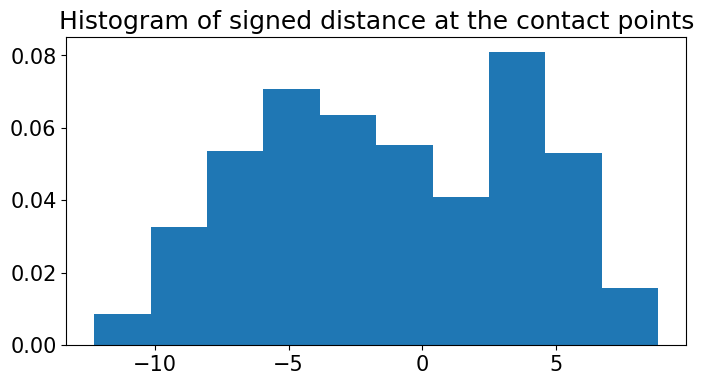

In [133]:
plt.hist(sdf_at_contact.reshape(-1),density = True)
plt.title('Histogram of signed distance at the contact points')

In [134]:
plus_pos = mc_pos_sdf[:,data==1]
minus_pos = mc_pos_sdf[:,data==0]

Text(0.5, 1.0, 'Borehole accuracy')

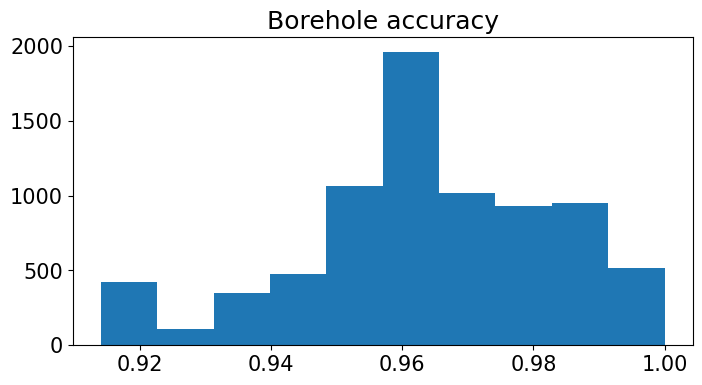

In [135]:
plt.rcParams["figure.figsize"] = (8, 4) 
plt.hist((np.sum(plus_pos>0,axis = 1)+np.sum(minus_pos<0,axis = 1))/(np.sum(data==0)+np.sum(data==1)))
plt.title('Borehole accuracy')

## Step 2: M(x) + R(x), Construct velocity with the above variance and do velocity extension

In [136]:
variance = np.var(sdf_at_contact.reshape(-1))

In [137]:
def extension_with_large_velocity(model):
    nx, ny = model.shape
    velocity = generate_m_2D([0,variance,20,20, np.random.uniform(0,180)], np.arange(nx), np.arange(ny), seed = None)
    # Here I choose the range 20 because trend can capture large scale variances larger than 20. 
    [_, F_eval] = skfmm.extension_velocities(model, velocity, dx=[1, 1],order = 1)
    
    max_iter_num = int(np.ceil(np.max(np.abs(F_eval))))
    for ii in range(max_iter_num):
        dt = 1/np.ceil(np.max(np.abs(F_eval)))
        delta_phi = dt * F_eval
        model_next = model - delta_phi # Advection
        model = skfmm.distance(model_next)
    return model

In [138]:
iter_num = 8100
print(model_cache.shape)
mc_pos_sdf_selected = model_cache[np.arange(cut_off,iter_num,100),:,:]

(8100, 258, 295)


In [139]:
mc_pos_sdf_plus_residual = np.zeros(mc_pos_sdf_selected.shape)
for i in tqdm(range(mc_pos_sdf_selected.shape[0])):
    mc_pos_sdf_plus_residual[i,:,:] = extension_with_large_velocity(mc_pos_sdf_selected[i,:,:])

100%|██████████| 78/78 [01:39<00:00,  1.27s/it]


## Step 3:  M(x) + R(x) with perfect match, Ensemble smoother for final matches

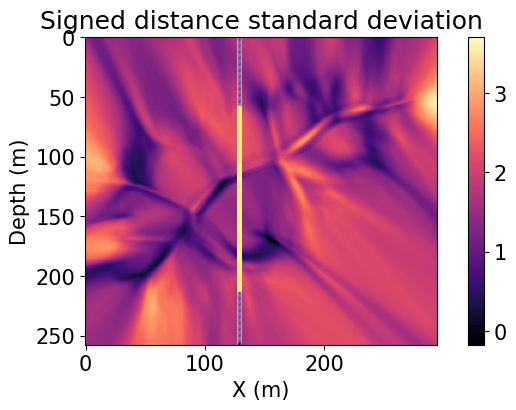

In [140]:
plt.imshow(np.std(mc_pos_sdf_plus_residual[:,:,:],axis = 0)-np.std(model_cache[1000:,:,:],axis = 0), cmap = 'magma')
plt.colorbar()
plt.title('Signed distance standard deviation')
plt.scatter(new_contacts['x'], new_contacts['depth'],
            c=new_contacts['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

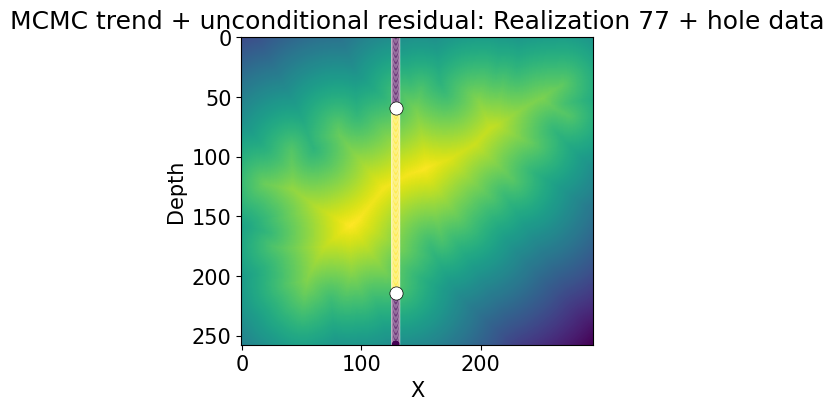

In [144]:
idx = 77
plt.imshow(mc_pos_sdf_plus_residual[idx,:,:])
plt.scatter(new_contacts['x'], new_contacts['depth'],
            c=new_contacts['litho'], edgecolors='w', linewidths=0.3)
plt.scatter(new_contacts['x'][new_contacts['contacts']==1], new_contacts['depth'][new_contacts['contacts']==1],
            c='w', edgecolors='k', linewidths=0.5,s=90)

plt.title('MCMC trend + unconditional residual: Realization '+str(idx)+' + hole data')
plt.ylabel('Depth'), plt.xlabel('X')
plt.show()

In [145]:
# Sigmoid on DT
def sigmoid(prior_DT):
    return 1/(1 + np.exp(-prior_DT*10))

def ensemble_smoother(m,d,d_obs):
    # no measurement error for now
    # covaraince matrix of d: cov_d
    cov_d = np.cov(d)
    # cross-covariance matrix: cov_m_d, m can be very large so I split into small piece and calculate the covariance matrix.
    start = 0
    sep = 1000
    cov_m_d = np.zeros((m.shape[0],d.shape[0]))
    for end in np.arange(0,m.shape[0],sep)+sep:
        cov_m_d[start:end,:] = np.cov(m[start:end,:],d)[:m[start:end,:].shape[0],m[start:end,:].shape[0]:]
        start = end

    K = np.dot(cov_m_d, np.linalg.inv(cov_d))
    m_pos = m + np.dot(K,d_obs-d)

    return m_pos

In [146]:
mc_pos_sdf_plus_residual_S_DT = sigmoid(mc_pos_sdf_plus_residual)

/var/folders/1c/056txszn77q0jr76_h81g4lm0000gn/T/ipykernel_60198/1161685376.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-prior_DT*10))


In [149]:
data[data == 0.5] = np.nan
d = mc_pos_sdf_plus_residual_S_DT[:,~np.isnan(data)]
d_obs = data[~np.isnan(data)]

d_obs = d_obs[np.var(d,axis = 0)>1e-6] # only invert boreholes with variance > 0.05. Mathemtically > 0 should be fine. 
d = d[:,np.var(d,axis = 0)>1e-6]

In [148]:
mc_pos_sdf_plus_residual_S_DT_pos = ensemble_smoother(mc_pos_sdf_plus_residual_S_DT.reshape(mc_pos_sdf_selected.shape[0],-1).T,
                                                      d.T,d_obs.reshape(-1,1)).T

In [151]:
borehole = new_contacts
def vis_ensembles_mean_var(plot_model):
    
    plt.rcParams['figure.figsize'] = 32, 10
    fig, axs = plt.subplots(1, 5)
    i = 0
    for ax in axs.flat[:3]:
        ax.imshow(plot_model[i*1+1,:,:]>0.5,vmin = 0, vmax = 1)
        ax.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3)
        ax.scatter(borehole['x'][borehole['contacts']==1], borehole['depth'][borehole['contacts']==1],
                    c='w', edgecolors='k', linewidths=0.5,s=90)
        ax.axis('off')
        ax.set_title('Realization '+str(i*100+1),fontsize = 25)
        i = i + 1

    ax = axs.flat[3]
    ax.imshow(np.mean(plot_model,axis = 0),vmin = 0, vmax = 1)
    ax.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3)
    ax.scatter(borehole['x'][borehole['contacts']==1], borehole['depth'][borehole['contacts']==1],
            c='w', edgecolors='k', linewidths=0.5,s=90)
    ax.axis('off')
    ax.set_title('Mean',fontsize = 25)

    ax = axs.flat[4]
    ax.imshow(np.var(plot_model,axis = 0),vmin = 0, vmax = 0.1)
    ax.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3)
    ax.scatter(borehole['x'][borehole['contacts']==1], borehole['depth'][borehole['contacts']==1],
            c='w', edgecolors='k', linewidths=0.5,s=90)    
    ax.axis('off')
    ax.set_title('Variance',fontsize = 25)

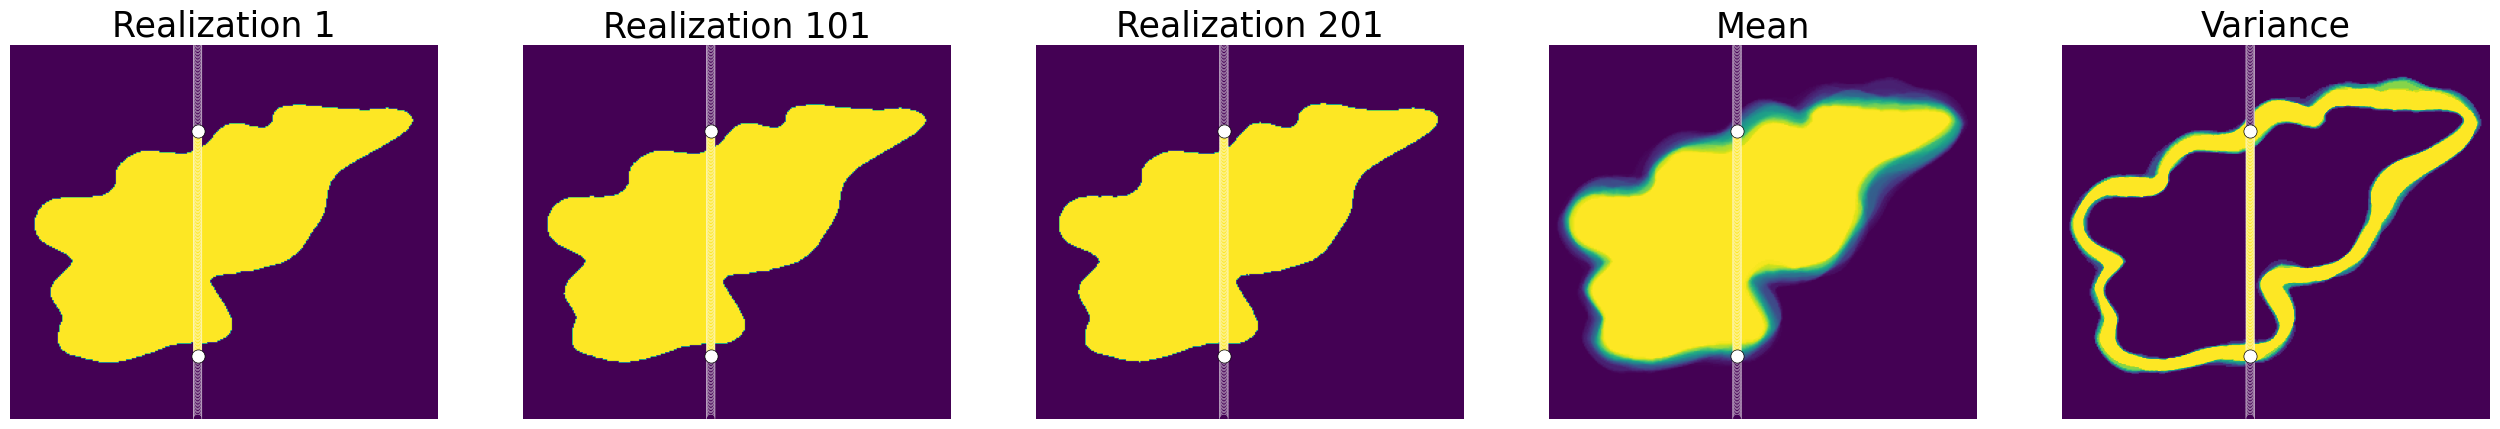

In [152]:
vis_ensembles_mean_var((mc_pos_sdf_selected>0)*1)

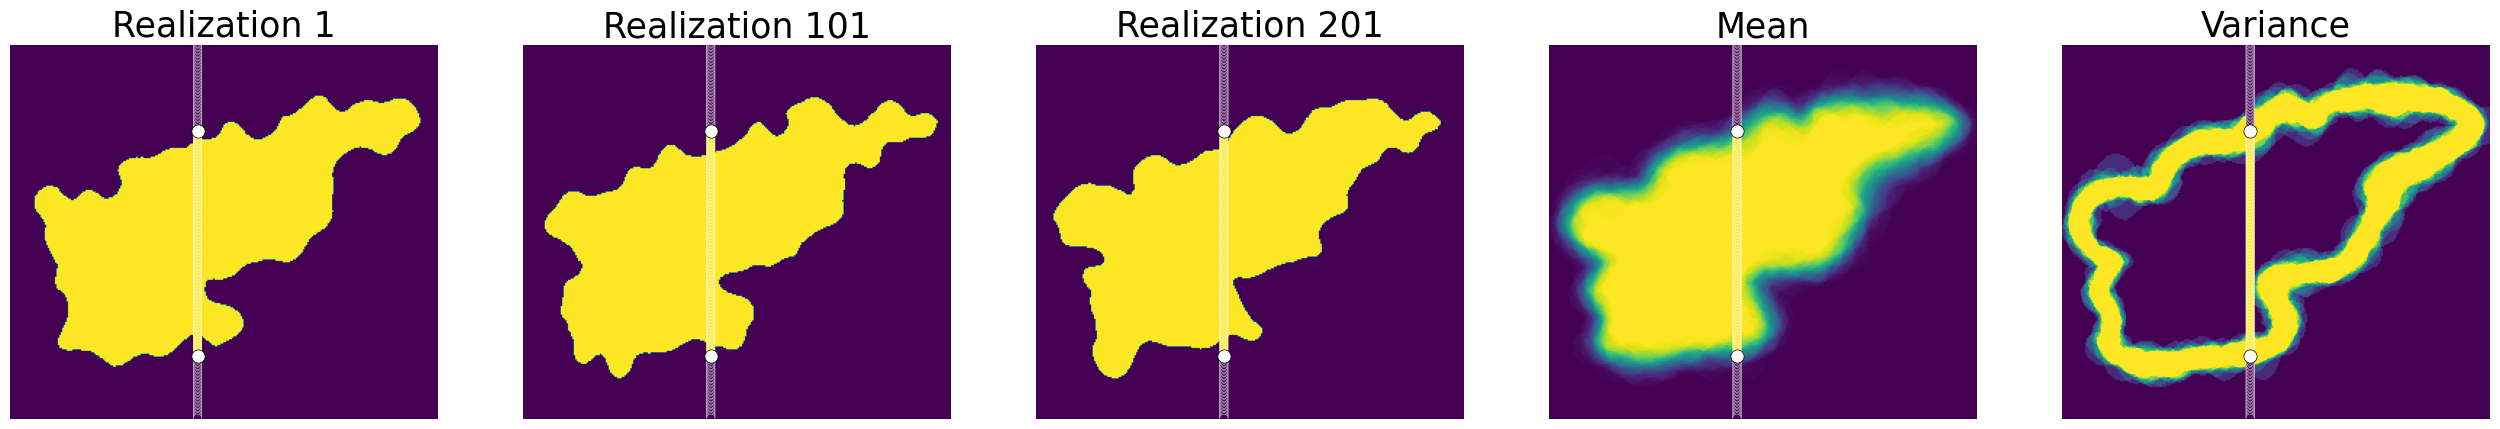

In [153]:
vis_ensembles_mean_var((mc_pos_sdf_plus_residual_S_DT>0.5)*1)

In [154]:
mc_pos_sdf_plus_residual_S_DT_pos = mc_pos_sdf_plus_residual_S_DT_pos.reshape(mc_pos_sdf_selected.shape)

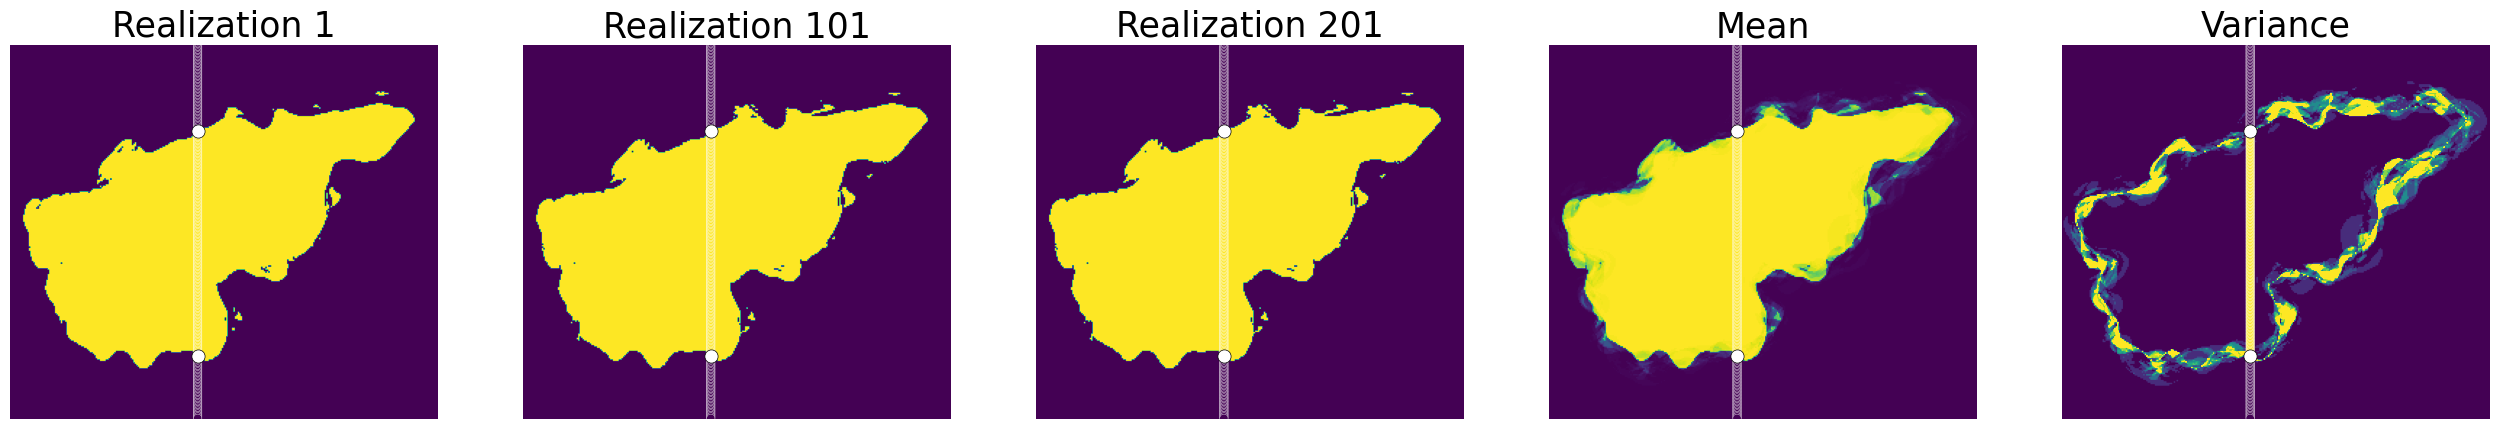

In [155]:
vis_ensembles_mean_var((mc_pos_sdf_plus_residual_S_DT_pos>0.5)*1)

In [156]:
plus_pos = mc_pos_sdf_plus_residual_S_DT_pos[:,data==1]
minus_pos = mc_pos_sdf_plus_residual_S_DT_pos[:,data==0]

(array([ 0.,  0.,  0.,  0.,  0., 78.,  0.,  0.,  0.,  0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

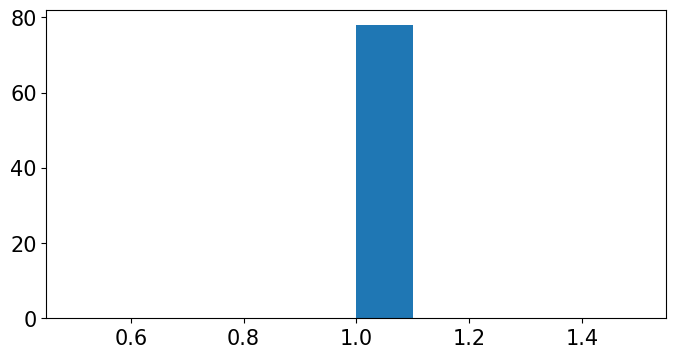

In [157]:
plt.rcParams["figure.figsize"] = (8, 4) 
plt.hist((np.sum(plus_pos>0.5,axis = 1)+np.sum(minus_pos<=0.5,axis = 1))/(np.sum(data==0)+np.sum(data==1)))